In [0]:
import imageio
import cv2
import numpy as np
import os
import pickle
import re
import PIL
from PIL import Image

## Challenge Categories

In [0]:
CATEGORIES = [
    "boxing",
    "handclapping",
    "handwaving",
    "jogging",
    "running",
    "walking"
]

IMG_W = 60
IMG_H = 80
CHANNELS = 1
INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
NCLASSES = 6

EPOCHS = 25
BATCH_SIZE = 64

### Spliting Dataset

In [0]:
# Dataset are divided according to the instruction at:
# http://www.nada.kth.se/cvap/actions/00sequences.txt
TRAIN_PEOPLE_ID = [11, 12, 13, 14, 15, 16, 17, 18]
DEV_PEOPLE_ID = [19, 20, 21, 23, 24, 25, 1, 4]
TEST_PEOPLE_ID = [22, 2, 3, 5, 6, 7, 8, 9, 10]

## Loading Dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
print("Loading dataset ..")
train_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/train.p", "rb"))
dev_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/dev.p", "rb"))
test_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/test.p", "rb"))

Loading dataset ..


##Preparing dataset

In [0]:
def read_ds(ds="train"):
  if(ds == "dev"):
    videos = dev_videos
  elif (ds == "test"):
    videos = test_videos
  else:
    videos = train_videos
      
  X = []
  y = []
  for video in videos:
      for frame in video["frames"]:
          X.append(frame.reshape(INPUT_SHAPE))
          y.append(CATEGORIES.index(video["category"]))

  X = np.array(X, dtype=np.float32)
  y = np.array(y, dtype=np.uint8)

  '''
  mean = np.mean(X)
  X -= float(mean)
  '''
  return X, y

In [0]:
X_train, y_train = read_ds(ds="train")
X_dev, y_dev = read_ds(ds="dev")
X_test, y_test = read_ds(ds="test")

In [9]:
X_train[0].shape

(60, 80, 1)

In [10]:
X_train.shape

(74672, 60, 80, 1)

In [11]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [12]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten
from keras.layers import Input, ZeroPadding2D, Conv2D, MaxPooling2D, Activation, add
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import plot_model

Using TensorFlow backend.


In [0]:
X_train_3 = X_train
X_dev_3 = X_dev
X_test_3 = X_test

In [0]:
X_train_3 = np.repeat(X_train_3[...,], 3, 3)
X_dev_3 = np.repeat(X_dev_3[...,], 3, 3)
X_test_3 = np.repeat(X_test_3[...,], 3, 3)

In [15]:
X_train_3.shape

(74672, 60, 80, 3)

In [0]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)
y_test = to_categorical(y_test)

In [0]:
# CNN model (VGG like)
model = Sequential()

## Stage 2
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(IMG_W, IMG_H, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))

## Stage 3
model.add(Conv2D(64,(3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))

## Stage 4
model.add(Conv2D(128,(3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))

## Output
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NCLASSES,activation='softmax'))

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 58, 78, 32)        896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 58, 78, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 76, 32)        9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 56, 76, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 38, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 36, 64)        18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 26, 36, 64)       

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
trained_model = model.fit(X_train_3, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data=(X_dev_3, y_dev) , shuffle=True)

Train on 74672 samples, validate on 72821 samples
Epoch 1/25
74672/74672 [==============================] - 42s 568us/step - loss: 0.7301 - acc: 0.6960 - val_loss: 1.3847 - val_acc: 0.5756
Epoch 2/25
74672/74672 [==============================] - 40s 542us/step - loss: 0.3379 - acc: 0.8541 - val_loss: 1.3829 - val_acc: 0.5746
Epoch 3/25
74672/74672 [==============================] - 41s 543us/step - loss: 0.2173 - acc: 0.9107 - val_loss: 1.4318 - val_acc: 0.5789
Epoch 4/25
74672/74672 [==============================] - 41s 545us/step - loss: 0.1642 - acc: 0.9340 - val_loss: 1.8628 - val_acc: 0.6034
Epoch 5/25
74672/74672 [==============================] - 41s 547us/step - loss: 0.1248 - acc: 0.9523 - val_loss: 1.6746 - val_acc: 0.5613
Epoch 6/25
74672/74672 [==============================] - 41s 545us/step - loss: 0.0980 - acc: 0.9642 - val_loss: 1.7993 - val_acc: 0.5936
Epoch 7/25
74672/74672 [==============================] - 41s 544us/step - loss: 0.0852 - acc: 0.9692 - val_loss: 1.

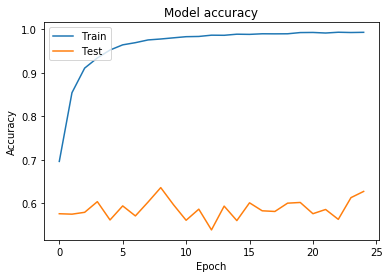

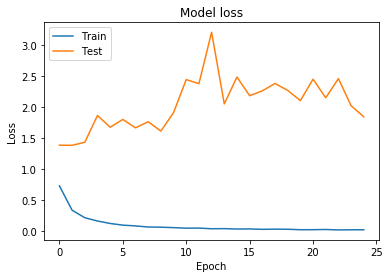

In [25]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(trained_model.history['acc'])
plt.plot(trained_model.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [29]:
model.evaluate(X_test_3, y_test)

79266/79266 [==============================] - 15s 191us/step


[2.320498157227808, 0.5706860444579013]

In [0]:
model.save_weights('CNN_3CHANNELS_KTH.h5')

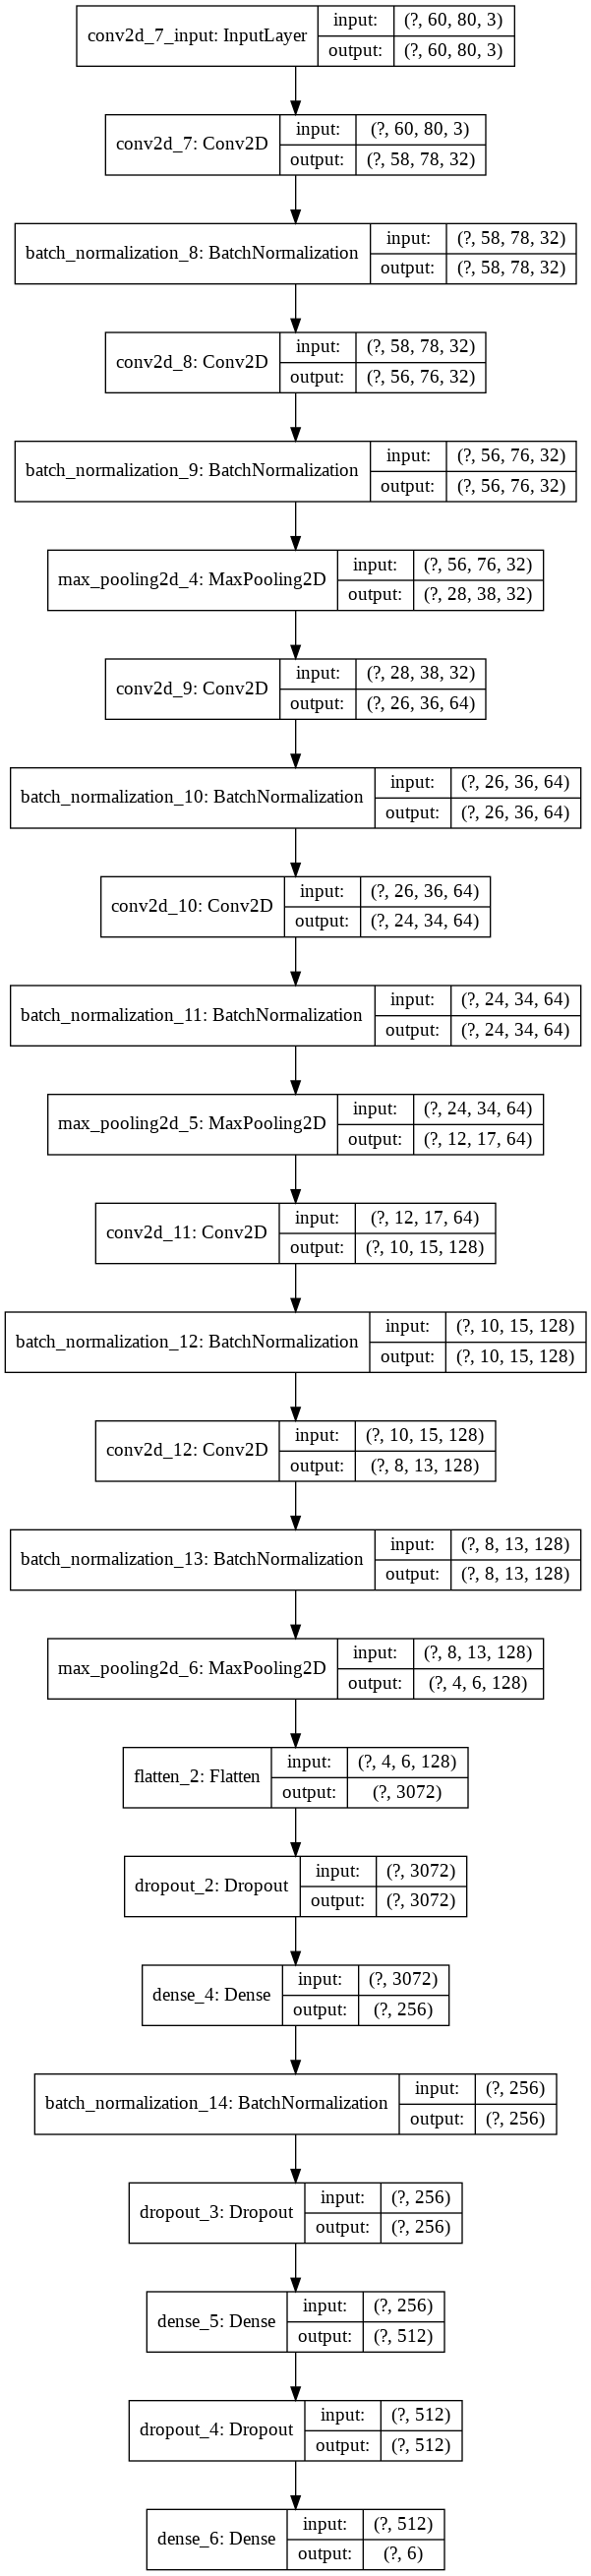

In [28]:
plot_model(model, show_shapes=True, to_file='CNN_3CHANNELS_KTH.png')